In [1]:
# ============================================================
# MINI PROJECT 1 — TEXT SENTIMENT (SKINCARE REVIEWS, ID)
# From Unstructured to Structured (Text) — Kaggle Version
# ============================================================

# 0) Install dependencies (run once per fresh session)
!pip -q install textblob deep-translator Sastrawi wordcloud pandas numpy matplotlib emoji regex

# 1) Imports
import re, os, time, math, string, unicodedata, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from textblob import TextBlob
from deep_translator import GoogleTranslator
from wordcloud import WordCloud
from collections import Counter
import emoji

# Optional (stemming Indonesian)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()

# 2) Load data
# ------------------------------------------------------------
# Opsi A: pakai file yang kamu upload (Excel/CSV)
# Ganti path sesuai file yang kamu upload ke Kaggle:
DATA_PATH = "/kaggle/input/data-latihan-psd/skincare_reviews_id_noise.xlsx"  # contoh kalau di Kaggle Datasets
# Opsi lokal sementara (kalau belum upload ke Datasets Kaggle): comment baris di atas dan uncomment baris di bawah
# DATA_PATH = "/kaggle/working/skincare_reviews_id_noise.csv"

# Auto-detect extension
ext = os.path.splitext(DATA_PATH)[1].lower()
if ext == ".xlsx":
    df = pd.read_excel(DATA_PATH)
else:
    df = pd.read_csv(DATA_PATH)

df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.6 MB/s eta 0:00:00:00:01


,id,review_raw
0,1,"dipakai paagi daan maalaam, 2 pump bngt ✨"
1,2,setelah seeminggu malah makin kusam krn
2,3,Leengkeet dan laama baanget nyeraapnya
3,4,"Wangiinya nyeengaat, puusing diipaake ga ✨"
4,5,"Setelah 7 hari, kulitku lebih cerah & halus 🤔"


In [2]:
# 3) Basic sanity check
assert "review_raw" in df.columns, "Kolom 'review_raw' harus ada pada dataset!"
df["review_raw"] = df["review_raw"].astype(str)
print("Total rows:", len(df))
print(df["review_raw"].head(5).to_string(index=False))

Total rows: 100
    dipakai paagi daan maalaam, 2 pump bngt ✨
      setelah seeminggu malah makin kusam krn
       Leengkeet dan laama baanget nyeraapnya
   Wangiinya nyeengaat, puusing diipaake ga ✨
Setelah 7 hari, kulitku lebih cerah & halus 🤔


In [3]:
# 4) Preprocessing helpers
# ------------------------------------------------------------
# Cleaning rules:
# - remove URLs, HTML tags
# - remove @mention, hashtag symbol (tapi boleh simpan kata setelah #)
# - remove emojis (atau opsional di-keep)
# - remove punctuation, numbers, extra spaces
# - normalize elongated chars (cooool -> cool) secukupnya
# - lowercasing
# - optional: slang normalization map (simple demo)
# - stopword removal (simple list + Sastrawi stemming optional)

URL_RE = re.compile(r"http\S+|www\.\S+")
HTML_RE = re.compile(r"<.*?>")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
NONALNUM_RE = re.compile(r"[^a-zA-Z\s]")
MULTISPACE_RE = re.compile(r"\s+")

# contoh very-small slang map (silakan panjangin sesuai kebutuhan)
SLANG_MAP = {
    "bgt":"banget", "bngt":"banget", "bangettt":"banget", "bangeet":"banget",
    "ga":"tidak", "gak":"tidak", "nggak":"tidak",
    "tp":"tapi", "krn":"karena", "yg":"yang", "udh":"sudah", "sm":"sama", "cmn":"cuma",
    "mantul":"mantap betul", "luv":"cinta"
}

# Small Indonesian stopwords (tambahkan sesuai kebutuhan)
ID_STOP = set("""
yang dan di ke dari untuk pada dengan karena tapi atau kalau bahwa agar
itu ini saya aku kamu dia mereka kami kita tidak iya iyaaa iyaaaa iyaaaaa
sih deh dong ya kok nih tuh sih lah si dong banget bangetnya bangettt nya
""".split())

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))

def normalize_slang(tokens):
    return [SLANG_MAP.get(t, t) for t in tokens]

def reduce_elongation(word):
    # kurangi pengulangan huruf (e.g., "baguuuusss" -> "baguus")
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

def tokenize_simple(text):
    return [w for w in text.split() if w]

def clean_text_id(s,
                  keep_emojis=False,
                  do_stemming=False,
                  remove_stopwords=True):
    # remove urls & html
    s = URL_RE.sub(" ", s)
    s = HTML_RE.sub(" ", s)

    # keep hashtag words but drop '#'
    s = HASHTAG_RE.sub(lambda m: f" {m.group(1)} ", s)

    # drop mentions
    s = MENTION_RE.sub(" ", s)

    # keep or strip emojis
    if not keep_emojis:
        s = emoji.replace_emoji(s, replace=" ")

    # lower & remove accents
    s = s.lower()
    s = strip_accents(s)

    # remove punctuation & numbers
    s = NONALNUM_RE.sub(" ", s)

    # reduce elongations
    s = " ".join(reduce_elongation(w) for w in s.split())

    # collapse spaces
    s = MULTISPACE_RE.sub(" ", s).strip()

    # slang normalize
    tokens = tokenize_simple(s)
    tokens = normalize_slang(tokens)

    # stopword removal
    if remove_stopwords:
        tokens = [t for t in tokens if t not in ID_STOP and len(t) > 1]

    # stemming (optional)
    if do_stemming:
        tokens = [stemmer.stem(t) for t in tokens]

    return " ".join(tokens)

# Apply cleaning
df["clean_id"] = df["review_raw"].apply(lambda x: clean_text_id(x,
                                                                keep_emojis=False,
                                                                do_stemming=False,
                                                                remove_stopwords=True))
df[["review_raw","clean_id"]].head(10)

,review_raw,clean_id
0,"dipakai paagi daan maalaam, 2 pump bngt ✨",dipakai paagi daan maalaam pump
1,setelah seeminggu malah makin kusam krn,setelah seeminggu malah makin kusam
2,Leengkeet dan laama baanget nyeraapnya,leengkeet laama baanget nyeraapnya
3,"Wangiinya nyeengaat, puusing diipaake ga ✨",wangiinya nyeengaat puusing diipaake
4,"Setelah 7 hari, kulitku lebih cerah & halus 🤔",setelah hari kulitku lebih cerah halus
5,"Kemasaan boocoor, isiinyaa tumpaah ga #gl...",kemasaan boocoor isiinyaa tumpaah glowing skin...
6,"baru seemingguu cobaa, beluum yaakin 🙈 @tokoon...",baru seemingguu cobaa beluum yaakin jerawat
7,mahal tapi hasilnya biasa aja parah sih #jeraw...,mahal hasilnya biasa aja parah jerawat
8,"tekstur gel, warna bening, adaa sedikiit wangi...",tekstur gel warna bening adaa sedikiit wangi k...
9,butuh waktu buat lihat hasilnya krn 👍✨ pls,butuh waktu buat lihat hasilnya pls


In [4]:
# 5) Translate to English (for TextBlob best performance)
# ------------------------------------------------------------
# Note: Translation requires internet. If fails, we'll fallback to original 'clean_id'.
def translate_to_en(text):
    if not text or text.strip()=="":
        return text
    try:
        return GoogleTranslator(source="auto", target="en").translate(text)
    except Exception as e:
        # fallback: return the original (TextBlob can still run, but quality may drop)
        return text

# To speed up, we can cache translations
translated = []
for i, txt in enumerate(df["clean_id"].tolist()):
    tr = translate_to_en(txt)
    translated.append(tr)
    if (i+1) % 10 == 0:
        print(f"Translated {i+1}/{len(df)}")
    time.sleep(0.2)  # gentle delay to avoid rate limiting

df["clean_en"] = translated
df[["clean_id","clean_en"]].head(10)

Translated 10/100
Translated 20/100
Translated 30/100
Translated 40/100
Translated 50/100
Translated 60/100
Translated 70/100
Translated 80/100
Translated 90/100
Translated 100/100


,clean_id,clean_en
0,dipakai paagi daan maalaam pump,Daan maalaam pump
1,setelah seeminggu malah makin kusam,After a week it got even duller
2,leengkeet laama baanget nyeraapnya,Lengkeet Laama Banget Nyerapnya
3,wangiinya nyeengaat puusing diipaake,the fragrance is very pleasant to use
4,setelah hari kulitku lebih cerah halus,after the day my skin is brighter and smoother
5,kemasaan boocoor isiinyaa tumpaah glowing skin...,The Boocoor packaging contains glowing skincare
6,baru seemingguu cobaa beluum yaakin jerawat,The horror of the Semning is not the drum of d...
7,mahal hasilnya biasa aja parah jerawat,"expensive, the results are usually bad acne"
8,tekstur gel warna bening adaa sedikiit wangi k...,The clear gel texture has a slight healthy ski...
9,butuh waktu buat lihat hasilnya pls,it will take time to see the results pls


In [5]:
# 6) Sentiment with TextBlob (polarity, subjectivity)
# ------------------------------------------------------------
def get_polarity_subj(s):
    if not isinstance(s, str) or s.strip()=="":
        return 0.0, 0.0
    tb = TextBlob(s)
    return tb.sentiment.polarity, tb.sentiment.subjectivity

pol, sub = [], []
for text in df["clean_en"].tolist():
    p, s = get_polarity_subj(text)
    pol.append(p); sub.append(s)

df["polarity"] = pol
df["subjectivity"] = sub

def label_sentiment(p):
    if p >  0.05: return "positive"
    if p < -0.05: return "negative"
    return "neutral"

df["sentiment"] = df["polarity"].apply(label_sentiment)
df["sentiment"].value_counts()

sentiment
neutral     61
positive    33
negative     6
Name: count, dtype: int64

In [6]:
# 7) Save the processed dataset
# ------------------------------------------------------------
OUT_CSV = "/kaggle/working/skincare_reviews_processed.csv"
df.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)
df.head()

Saved: /kaggle/working/skincare_reviews_processed.csv


,id,review_raw,clean_id,clean_en,polarity,subjectivity,sentiment
0,1,"dipakai paagi daan maalaam, 2 pump bngt ✨",dipakai paagi daan maalaam pump,Daan maalaam pump,0.000000,0.0,neutral
1,2,setelah seeminggu malah makin kusam krn,setelah seeminggu malah makin kusam,After a week it got even duller,0.000000,0.0,neutral
2,3,Leengkeet dan laama baanget nyeraapnya,leengkeet laama baanget nyeraapnya,Lengkeet Laama Banget Nyerapnya,0.000000,0.0,neutral
3,4,"Wangiinya nyeengaat, puusing diipaake ga ✨",wangiinya nyeengaat puusing diipaake,the fragrance is very pleasant to use,0.953333,1.0,positive
4,5,"Setelah 7 hari, kulitku lebih cerah & halus 🤔",setelah hari kulitku lebih cerah halus,after the day my skin is brighter and smoother,0.000000,0.0,neutral


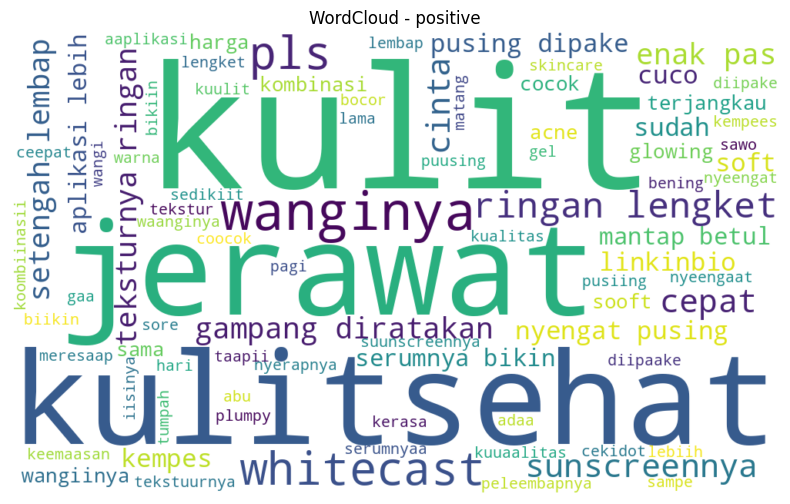

Saved: /kaggle/working/plots/wordcloud_positive.png


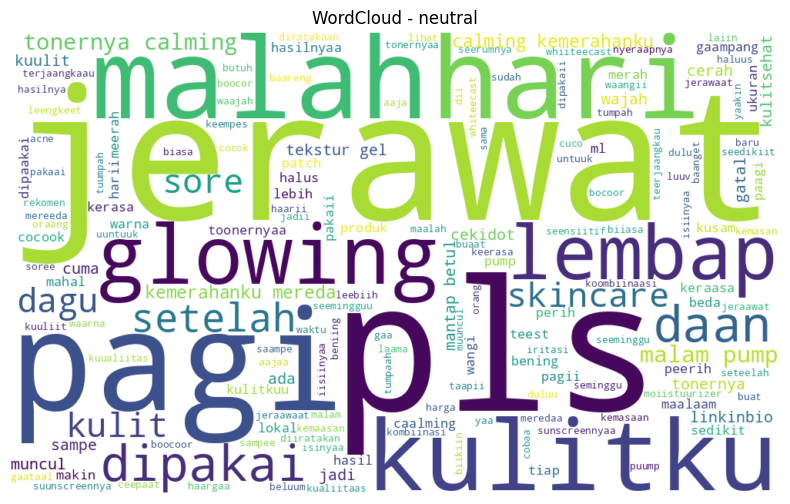

Saved: /kaggle/working/plots/wordcloud_neutral.png


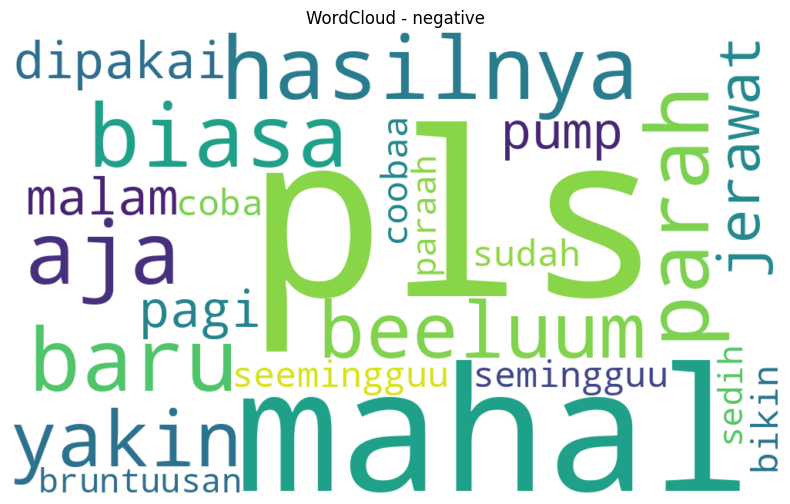

Saved: /kaggle/working/plots/wordcloud_negative.png


In [7]:
# 8) WordCloud per sentiment
# ------------------------------------------------------------
# Prepare text for each class
def join_text(series):
    return " ".join([str(s) for s in series if isinstance(s, str)])

sentiments = ["positive","neutral","negative"]
os.makedirs("/kaggle/working/plots", exist_ok=True)

for s in sentiments:
    text_s = join_text(df.loc[df["sentiment"]==s, "clean_id"])
    if not text_s.strip():
        print(f"[WARN] No text for {s}")
        continue
    wc = WordCloud(width=1000, height=600, background_color="white").generate(text_s)
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {s}")
    out_path = f"/kaggle/working/plots/wordcloud_{s}.png"
    plt.savefig(out_path, bbox_inches="tight", dpi=150)
    plt.show()
    print("Saved:", out_path)

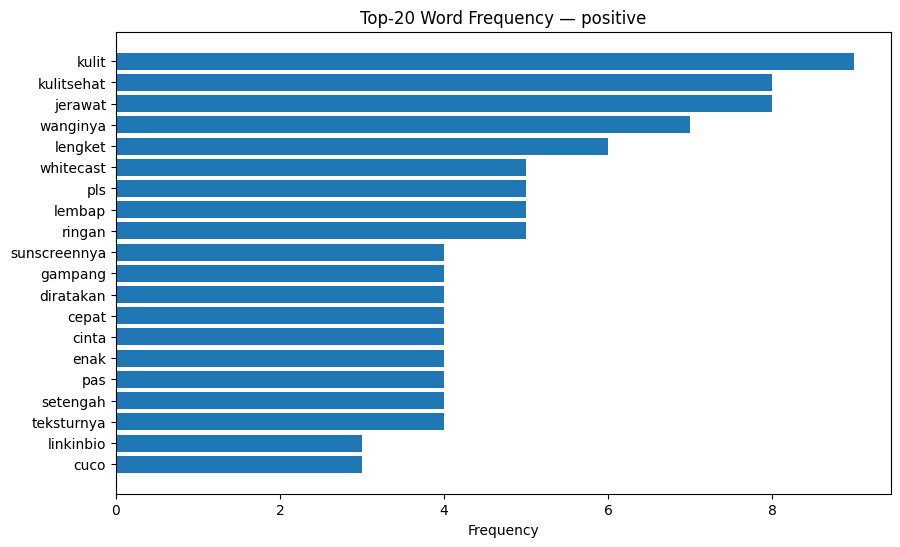

Saved: /kaggle/working/plots/wordfreq_positive.png


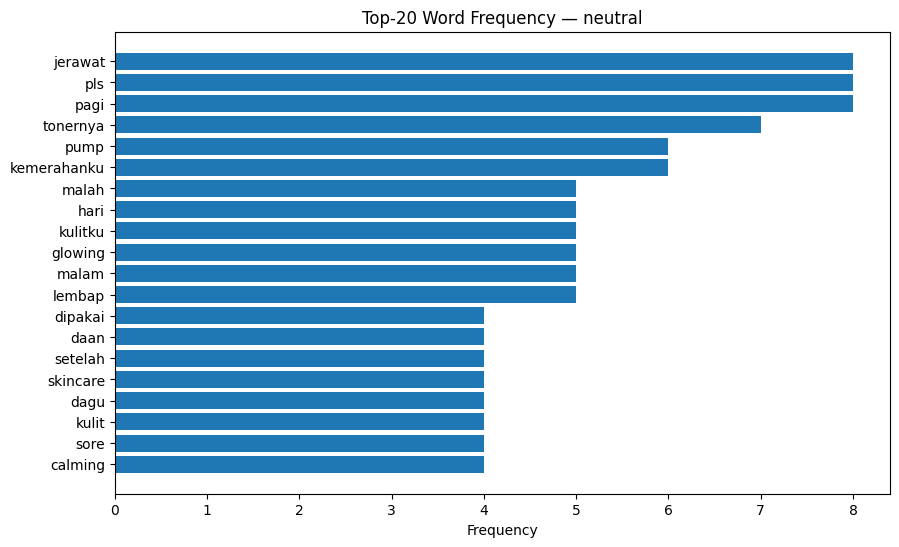

Saved: /kaggle/working/plots/wordfreq_neutral.png


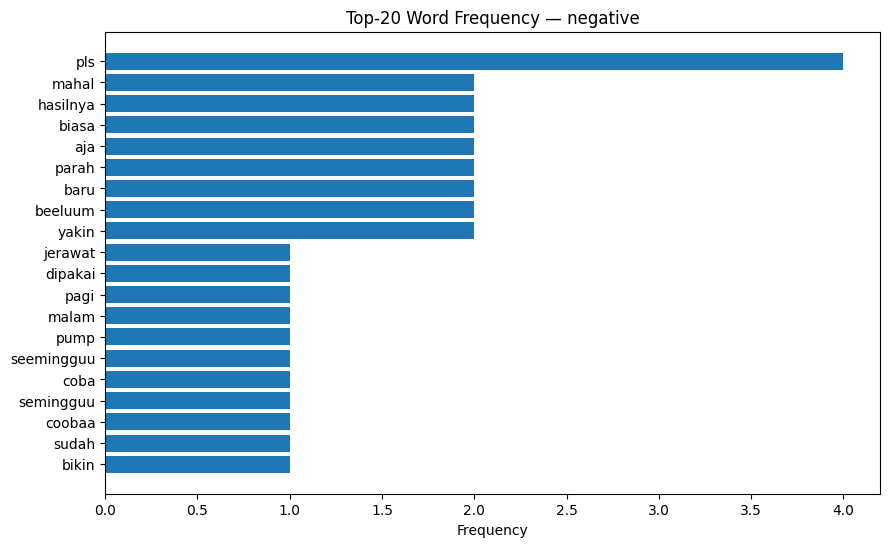

Saved: /kaggle/working/plots/wordfreq_negative.png


In [8]:
# 9) Word Frequency Bar Chart per sentiment (Top-20)
# ------------------------------------------------------------
def get_top_words(text, topk=20):
    tokens = [t for t in text.split() if len(t) > 1]
    return Counter(tokens).most_common(topk)

for s in sentiments:
    text_s = join_text(df.loc[df["sentiment"]==s, "clean_id"])
    if not text_s.strip():
        print(f"[WARN] No text for {s}")
        continue
    top_words = get_top_words(text_s, topk=20)
    words = [w for w,_ in top_words]
    freqs = [c for _,c in top_words]

    plt.figure(figsize=(10,6))
    y_pos = np.arange(len(words))
    plt.barh(y_pos, freqs)  # matplotlib only, single plot, no custom colors
    plt.yticks(y_pos, words)
    plt.xlabel("Frequency")
    plt.title(f"Top-20 Word Frequency — {s}")
    plt.gca().invert_yaxis()
    out_path = f"/kaggle/working/plots/wordfreq_{s}.png"
    plt.savefig(out_path, bbox_inches="tight", dpi=150)
    plt.show()
    print("Saved:", out_path)

In [9]:
# 10) Quick EDA summary by sentiment
# ------------------------------------------------------------
summary = df.groupby("sentiment").agg(
    n=("sentiment","size"),
    polarity_mean=("polarity","mean"),
    subjectivity_mean=("subjectivity","mean")
).reset_index()
summary

,sentiment,n,polarity_mean,subjectivity_mean
0,negative,6,-0.391667,0.809722
1,neutral,61,-0.001093,0.030328
2,positive,33,0.410960,0.570455
